In [1]:
import sys
sys.path.append('../..')

import pyotc

PyOTC loaded.
Software version is: 0.3.2


### Density of water

In [2]:
from scipy import array, arange

rho = array([0.99984,
             0.99970,
             0.99821,
             0.99565,
             0.99222,
             0.98803,
             0.98320,
             0.97778,
             0.97182,
             0.96535,
             0.95840
             ]) * 1000

temp = array(arange(0, 101, 10, dtype=float))

In [3]:
from lmfit import Parameters, Model, report_fit

pars = Parameters()
pars.add('a', value=-1, vary=True, min=None, max=None)
pars.add('b', value=0, vary=True, min=None, max=None)
pars.add('c', value=0, vary=True, min=None, max=None)
pars.add('d', value=0, vary=True, min=None, max=None)

p3 = lambda a, b, c, d, t0, temp: a * (temp-t0)**3 + b * (temp-t0)**2 + c * (temp-t0) + d

t0 = 0.0 # degC

poly3 = Model(lambda a, b, c, d, temp: p3(a, b, c, d, t0, temp),
              name='poly3',
              independent_vars=['temp'],
              param_names=['a', 'b', 'c', 'd'])


poly3_res = poly3.fit(rho,
                      temp=temp,
                      params=pars
                      )

report_fit(poly3_res)

[[Fit Statistics]]
    # function evals   = 13
    # data points      = 11
    # variables        = 4
    chi-square         = 0.077
    reduced chi-square = 0.011
    Akaike info crit   = -41.639
    Bayesian info crit = -40.048
[[Variables]]
    a:   1.5690e-05 +/- 1.33e-06 (8.49%) (init=-1)
    b:  -0.00591743 +/- 0.000203 (3.43%) (init= 0)
    c:   0.02020695 +/- 0.008478 (41.96%) (init= 0)
    d:   999.949648 +/- 0.093101 (0.01%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.984 
    C(b, c)                      = -0.959 
    C(a, c)                      =  0.899 
    C(c, d)                      = -0.769 
    C(b, d)                      =  0.609 
    C(a, d)                      = -0.515 


<IPython.core.display.Javascript object>


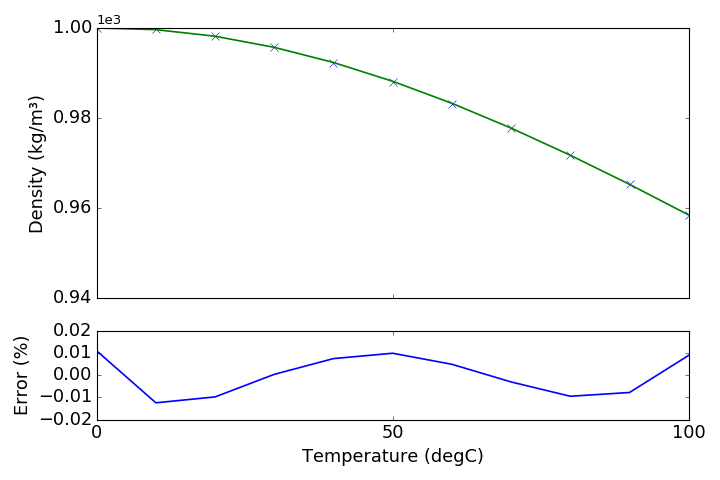

In [4]:
import matplotlib.pyplot as plt

from pyotc.plotting import get_residual_plot_axes, add_plot_to_figure

plt.ion()
fig = plt.figure(figsize=(9, 6))

ax1, ax2 = get_residual_plot_axes(figure=fig)[0]

add_plot_to_figure(fig, temp, rho, fmt='x', axis=ax1)
add_plot_to_figure(fig, temp, poly3_res.eval(), axis=ax1)
ax1.set_xlabel('')
ax1.set_xticklabels([])
ax1.set_ylabel('Density (kg/m³)')

add_plot_to_figure(fig, temp, poly3_res.residual / rho * 100, axis=ax2)
ax2.set_ylabel('Error (%)')
ax2.set_xlabel('Temperature (degC)');
fig.tight_layout()


### Viscosity of water

[[Fit Statistics]]
    # function evals   = 19
    # data points      = 11
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -274.042
    Bayesian info crit = -272.848
[[Variables]]
    b:   0.03586866 +/- 0.000287 (0.80%) (init= 0.03586)
    c:   0.00018829 +/- 4.93e-06 (2.62%) (init= 0.00019)
    a:   0.00179461 +/- 2.88e-06 (0.16%) (init= 1.79458)
[[Correlations]] (unreported correlations are <  0.100)
    C(b, c)                      = -0.801 
    C(b, a)                      =  0.620 
    C(c, a)                      = -0.237 


<IPython.core.display.Javascript object>


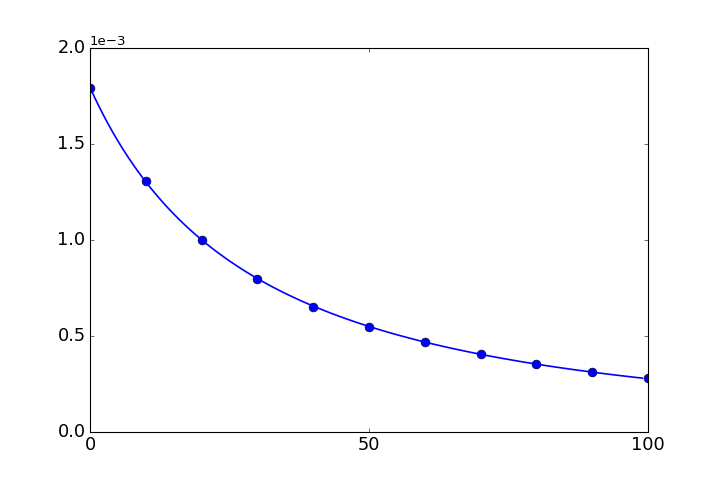

[[Fit Statistics]]
    # function evals   = 120
    # data points      = 11
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -274.042
    Bayesian info crit = -272.848
[[Variables]]
    b:  -0.01275814 +/- 0.000496 (3.89%) (init= 0.03586)
    c:   3.5857e-05 +/- 2.03e-06 (5.66%) (init= 0.00019)
    a:   0.00034175 +/- 2.84e-05 (8.30%) (init= 1.79458)
[[Correlations]] (unreported correlations are <  0.100)
    C(b, c)                      = -1.000 
    C(c, a)                      =  0.999 
    C(b, a)                      = -0.999 


<IPython.core.display.Javascript object>


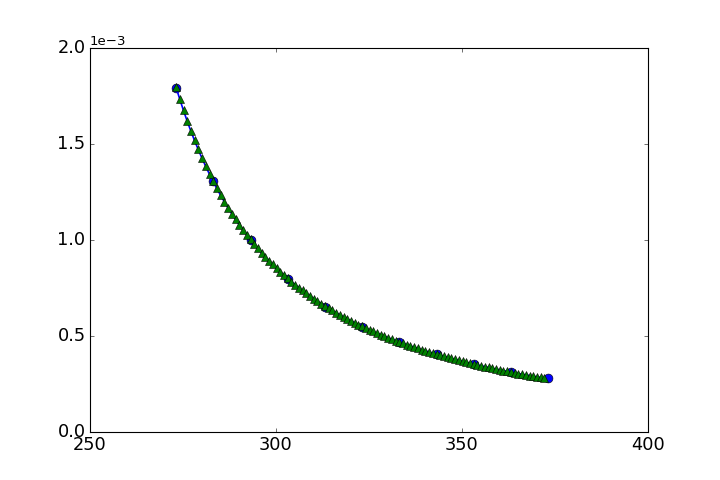

In [6]:
#determine a, b, and c with resp. to Kelvin
from pyotc.physics import viscosity_H2O
from numpy import vectorize

from scipy import array, arange
from pyotc.psd_fitting import gen_fit_pars

eta_CRC = array([1793,
                 1307,
                 1002,
                 797.7,
                 653.2,
                 547.0,
                 466.5,
                 404.0,
                 354.4,
                 314.5,
                 281.8
                 ]) * 1e-6

T_CRC = array([0, 10 ,20, 30, 40, 50, 60, 70, 80, 90, 100])

from lmfit import Model, report_fit

def fitfun(T, a, b, c):
    return a / (1 + b * T + c * T**2)

pars = gen_fit_pars(a = 1.79458, b = 0.03586, c = 0.00019)

# celsius model
mdl = Model(fitfun, independent_vars=['T'])
mzr = mdl.fit(eta_CRC, T=T_CRC, params=pars)
report_fit(mzr)
pars_fit = mzr.params

ax = pyotc.add_plot_to_figure(None, T_CRC, eta_CRC, fmt='ob')
fig = ax.figure

t_degC = arange(0, 100, 1)
pyotc.add_plot_to_figure(fig, t_degC, fitfun(t_degC, pars_fit['a'].value, pars_fit['b'].value, pars_fit['c'].value))

# kelvin model
mzr2 = mdl.fit(eta_CRC, T=T_CRC+273.15, params=pars)
report_fit(mzr2)
pars_fit2 = mzr2.params

ax = pyotc.add_plot_to_figure(None, T_CRC+273.15, eta_CRC, fmt='ob')
fig = ax.figure

t_K = arange(0, 100, 1) + 273.15
pyotc.add_plot_to_figure(fig, t_K, fitfun(t_K, pars_fit2['a'].value, pars_fit2['b'].value, pars_fit2['c'].value));
pyotc.add_plot_to_figure(fig, t_K, vectorize(viscosity_H2O)(t_K), fmt='^')

#fig

### Comparing Viscosity formulas: CRC Handbook fit to other Equations 

### Kinematic viscosity of water

<IPython.core.display.Javascript object>


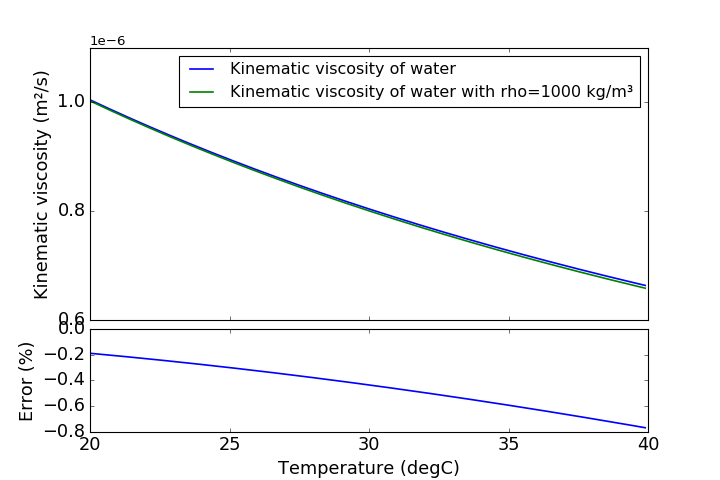

In [8]:
from pyotc.physics import kinematic_viscosity_H2O, viscosity_H2O
from numpy import vectorize

vkin = vectorize(kinematic_viscosity_H2O)
vvis = vectorize(viscosity_H2O)

temp = arange(20.0, 40.0, 0.1, dtype=float)

ax1, ax2 = get_residual_plot_axes()[0]
fig = ax1.figure

temp = arange(20.0, 40.0, 0.1, dtype=float)
kin_vis =  vkin(temp + 273.15)

kin_vis_1000 = vvis(temp + 273.15) / 1000


add_plot_to_figure(fig, temp, kin_vis,
                   axis=ax1, label='Kinematic viscosity of water')
add_plot_to_figure(fig, temp, kin_vis_1000,
                   axis=ax1, label='Kinematic viscosity of water with rho=1000 kg/m³',
                   showLegend=True)
ax1.set_xlabel('')
ax1.set_xticklabels([])
ax1.set_ylabel('Kinematic viscosity (m²/s)');

add_plot_to_figure(fig, temp, (kin_vis_1000 - kin_vis)/kin_vis * 100, axis=ax2, label='Error')
ax2.set_xlabel('Temperature (degC)')
ax2.set_ylabel('Error (%)');


<IPython.core.display.Javascript object>


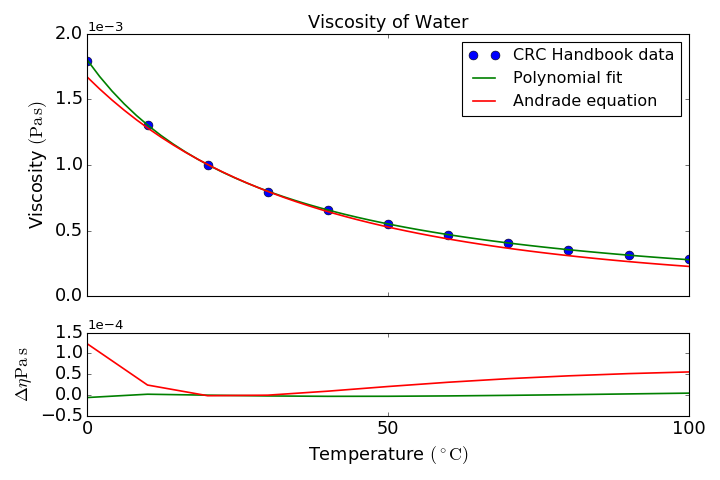

In [9]:
from scipy import linspace, power, exp, array

#viscosity_wiki = lambda T: 2.414e-5 * power(10, (247.8 / (T-140)))
viscosity_wiki2 = lambda a, b, T: exp(a + b/T) * 1e-3

eta_CRC = array([1793,
                 1307,
                 1002,
                 797.7,
                 653.2,
                 547.0,
                 466.5,
                 404.0,
                 354.4,
                 314.5,
                 281.8
                 ]) * 1e-6

T_CRC = array([0, 10 ,20, 30, 40, 50, 60, 70, 80, 90, 100])

T_fine =  linspace(0, 100, 50)
v_CRC = vvis(T_fine + 273.15)

#v_wiki = viscosity_wiki(T_fine)
v_wiki2 = viscosity_wiki2(-6.944, 2036.8, T_fine + 273.15)


fig = plt.figure(figsize=(9,6))

ax1, ax2 = get_residual_plot_axes(figure=fig)[0]

add_plot_to_figure(fig, T_CRC, eta_CRC, fmt='o', label='CRC Handbook data', axis=ax1)
add_plot_to_figure(fig, T_fine, v_CRC, fmt='-g', label='Polynomial fit', axis=ax1)
add_plot_to_figure(fig, T_fine, v_wiki2,
                   fmt='-r',
                   label='Andrade equation',
                   axis=ax1,
                   title='Viscosity of Water',
                   ylabel=r'Viscosity $(\mathrm{Pa\,s})$',
                   showLegend=True)
ax1.set_xticklabels([])
ax1.set_xlabel('')

add_plot_to_figure(fig, T_CRC, (eta_CRC - vvis(T_CRC + 273.15)),# / eta_CRC,
                   axis=ax2,
                   fmt='-g',
                   label='deviation of fit from CRC Handbook data'
                   )
add_plot_to_figure(fig, T_CRC, eta_CRC - viscosity_wiki2(-6.944, 2036.8, T_CRC + 273.15),# / eta_CRC,
                   axis=ax2,
                   fmt='-r',
                   label='deviation of wiki equation from CRC Handbook data',
                   xlabel=r'Temperature $(\mathrm{^\circ C})$',
                   ylabel=r'$\Delta\eta \mathrm{Pa\,s}$'
                   );
fig.tight_layout()